<a href="https://colab.research.google.com/github/sgangoly/QML/blob/QML-for-Fintech/QML_fintechfinance_quantum_born_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install qiskit-optimization ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install qiskit-machine-learning ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install qiskit-ignis ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install qiskit-nature ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:

# Libraries for circuits
from qiskit import QuantumCircuit, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister

# QVCs
from qiskit.circuit import ParameterVector

# SPSA optimizers
from qiskit.algorithms.optimizers import SPSA

# Visualisation
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np

# Additional visualization libraries
import matplotlib.pyplot as plt
import pylatexenc
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()

**Datasets: Bars & Stripes** (ref [3]: Benedetti et al.)

For this particular example, we considered a toy dataset of a Bar And Stripe (BAS) model as per the above ref [3]. This is composed of binary images of size 2x2. For this exercise only a subset of the dataset is used, as follows:

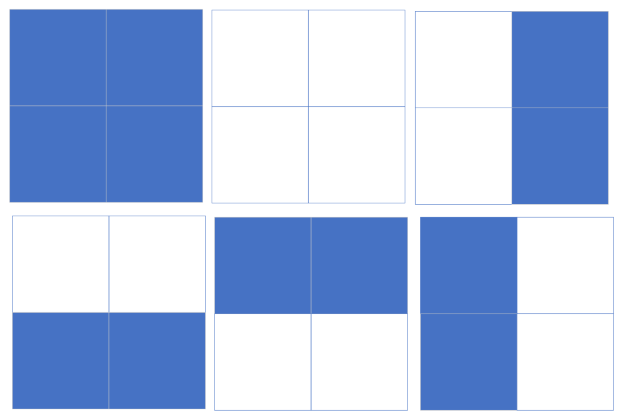

## Image to qubit mapping:

The qubits were mapped considering the fact that they only take two different values, namely, black-white, 0-255, 0-1. The Basis Encoding method was used for quantum encoding, to convert images into quantum state, where each pixel is represented as a qubit, for example:

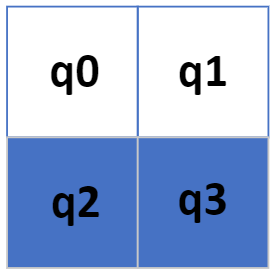

In [ ]:
n_qubits = 4 # number of qubits
ind_list = [0,3,5,10,12,15]  #indices 
len_sv = int(n_qubits**2) #length of statevector (SV)
px_output = np.zeros(len_sv) #initialise the SV with zeros of size n_qubits^2

for init_value in ind_list: #identify index of each SV
    px_output[init_value] = 1/np.sqrt(len(ind_list)) #normalize the statevector

px_output #print if this is correct  

array([0.40824829, 0.        , 0.        , 0.40824829, 0.        ,
       0.40824829, 0.        , 0.        , 0.        , 0.        ,
       0.40824829, 0.        , 0.40824829, 0.        , 0.        ,
       0.40824829])

In [ ]:
np.sum(px_output**2) ##  equivalent to | \alpha_i |^2

1.0000000000000002

##### The vector needs to be converted from a list to a dictionary (dict) before a histogram plot can be generated.

In [ ]:
## plot_histogram method

dict_px_output = {}  # dict variable for the histogram 

for elements in  zip(px_output, range(int(n_qubits**2)) ): # do an iteration with the list values and its index
    key = (bin(elements[1])[2:]) # obtain the bin number with the format 0b000, with [:2] remove the values 0b
    while len(key) < n_qubits: # all the keys need the same length which is equal to the number of qubits
        key = "0"+key            # add 0 in case the length is less than number of qubits  
    dict_px_output[key] = elements[0]  # map the index value in a bin number and into a key for the dict

This should be a uniform distribution of the following 6 states: **0000, 0011, 0101, 1010, 1100, 1111**, else, it is 0. The probability is given by the following expression $|\frac{1}{6}|^2 = \frac{1}{6} =0.167 $.

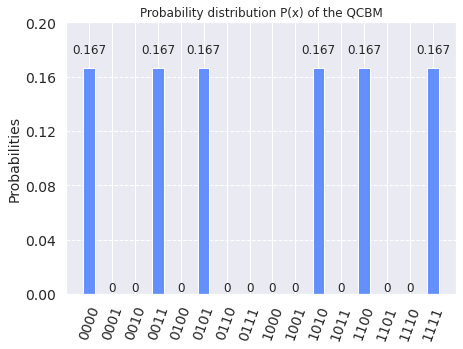

In [ ]:
plot_histogram(dict_px_output, title='Probability distribution P(x) of the QCBM') #plot the distribution 

**Designing a Variational Quantum Circuit (Layer)**
The QCBM design requires a Variational Quantum Circuit or ansatz that has multiple layers. The computation can be repeated as many times as required in order to obtain the desired Probability distribution.

Qiskit has several implemented ansatz such as RealAmplitude. This particular method requires the parameters number of qubits and the number of repetitions or  number of layers.

Google Colab specifically requires support of **pylatexenc** for matplotlibdraw operations. Hence, prior to any further exceution, pylatexenc was downloaded at a prior step:

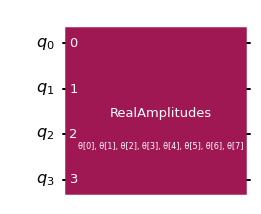

In [ ]:

# import ansatz 
from qiskit.circuit.library import RealAmplitudes

#this ansatz only requires the number of qubits  and the repetitions
ansatz_example = RealAmplitudes(n_qubits, reps=1) 


ansatz_example.draw("mpl", style='iqx')

As per the authors of Zhu [1] paper and [3] , Mølmer-Sørensen XX gates were chosen for the even layers only and arbitrary single qubit rotations were chosen for the odd layers of the VQC. Since the paper addresses a trapped ion architecture, the ParameterVector class was chosen to design the ansatz - this allows generation of gates with values.

In [ ]:
## Ansatz design
# In this work, we use arbitrary single qubit rotations for the odd layers, and Mølmer-Sørensen XX gates for the even layers
#
def ansatz_odd(n,parameters): # arbitrary single qubit rotations in the odd layer
    qc = QuantumCircuit(n) 
    
    for i in range(n):
        qc.u(parameters[3*i],parameters[1+(3*i)],parameters[2+(3*i)],i) #variable value for Ry with the values parameters[i]
    return qc

def ansatz_even(n,parameters): # Mølmer-Sørensen XX gates for the even layer
    qc = QuantumCircuit(n)
    k = n//2
    for i in range(k):
        qc.rxx(parameters[i],i*2,(2*i)+1)
    for i in range(k):
        qc.rxx(parameters[i+k],k-i-1,k)
    for i in range(k):
        qc.rxx(parameters[i+k*2],k-i-1,k+1)

    return qc

Design the U gate with a list of parameters

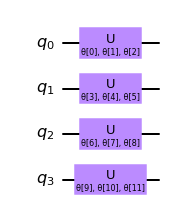

In [ ]:
# Control with changing the num_parameters value
num_parameters_odd = 12 # define 12 parametrs for 4 qubits
parameters_odd = ParameterVector('θ', num_parameters_odd) # define the vector θ

ansatz_odd(n_qubits,parameters_odd).draw("mpl") # draw own odd layer

The even layer was created with the XX and using the gate summation with Rxx() 

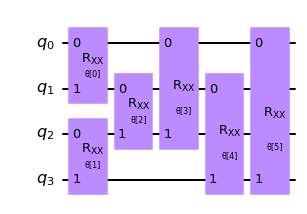

In [ ]:
num_parameters_even = 6 #how is 4 qubits we required 6 parametrs
parameters_even = ParameterVector('θ', num_parameters_even) # define the vector θ

ansatz_even(n_qubits,parameters_even).draw("mpl") # draw own  even layer

**Applying *n* layers**

Using a Qiskit method in the QuantumCircuit object the ansatz was converted into quantum gates. variable num_layers was used to define repaetations.

In [ ]:
## ansatz to quantum gate
def gate_layer(n, params,flag):
    if flag == 1:
        parameters = ParameterVector('θ', num_parameters_odd)
        qc = ansatz_odd(n,parameters) # odd layer
    else:
        parameters = ParameterVector('θ', num_parameters_even)
        qc = ansatz_even(n,parameters) # even layer
    params_dict = {}
    j = 0
    for p in parameters:
        # The name of the value will be the string identifier and an integer specifying the vector length
        params_dict[p] = params[j] 
        j += 1
    # Assign parameters using the assign_parameters method
    qc = qc.assign_parameters(parameters = params_dict)
    qc_gate = qc.to_gate()
    qc_gate.name = "layer" # show circuit
    return qc_gate #return a quantum gate

A quantum circuit with 5 layers were created  There were two gates that were interleaved for each layer and these have different quantity of parameters - hence,  max(parameters_odd, parameters_even) were tried out to find the gate with a higher number of parameters.

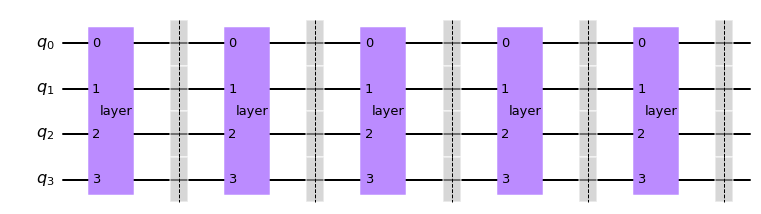

In [ ]:
#  quantum circuit

num_layers = 5
list_n = range(n_qubits)

num_layers

num_parameters = max(num_parameters_odd,num_parameters_even)

params = np.random.random([num_layers*num_parameters]) #all the parameters
qc_gate = QuantumCircuit(n_qubits)


for i in range(len(params)//num_parameters):
    #apply a function to consider m layers
    qc_gate.append(gate_layer(n_qubits,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    qc_gate.barrier()
qc_gate.draw("mpl")


Interleaving was verified using the decompose() method. It was confirned that the same circuit was repeated in layers (odd and even).

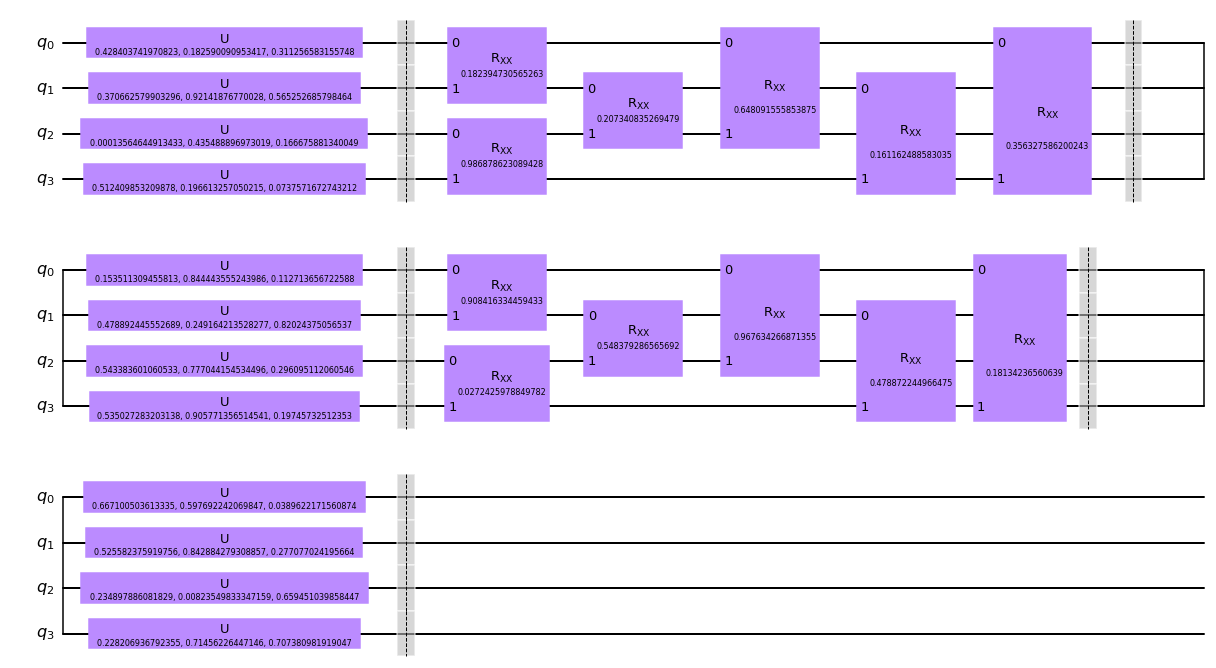

In [ ]:
qc_gate.decompose().draw("mpl")

A method called born_machine(params) was defined for purpsoe of optimizing the cost function

In [ ]:
cost_c = []


def born_machine(params):
    clear_output(wait=True)
    n=4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost +=(np.log10(max(0.001,statevector[j].real*px_output[j].real+(statevector[j].imag*px_output[j].imag))))
    cost = -cost/D
    #print(cost)
    cost_c.append(cost)
    plt.plot(cost_c,label='cost')
    plt.legend(['cost'])
    plt.show()
    return cost

num_layers = 6
params = np.random.random([num_layers*num_parameters]) 

At this point the data mapping process and the quantum circuit that represents the QCBM were in place. Now, the optimization section and the cost function needed to be defined. This was done using quantum circuits and the classical SPSA optimization as per the authors.

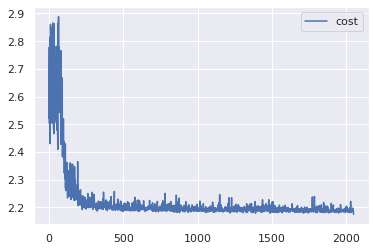

Execution time in seconds: 492.2133686542511


In [ ]:
import time
startTime = time.time()

cost_spsa = []

params_spsa = params
maxiter = 1000

optimizer_spsa = SPSA(maxiter=maxiter)
ret = optimizer_spsa.optimize(num_vars=len(params),objective_function=born_machine, initial_point=params_spsa)
params_spsa = ret[0]
cost_spsa = cost_c
cost_c = []

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

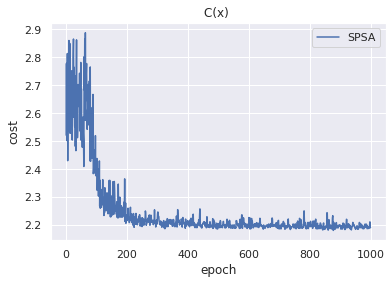

Execution time in seconds: 0.18743062019348145


In [ ]:
import time
startTime = time.time()

xfit = range(maxiter)

plt.plot(xfit, cost_spsa[:maxiter], label='SPSA')

plt.legend()
plt.title("C(x) ")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

The born_machine_final method is performed to obtain P(x)

In [ ]:
def born_machine_final(params):
    n=4
    list_n = range(n)
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
   
    return result

**Visualization**

In [ ]:
psi_vqc_spsa =  born_machine_final(params_spsa)
psi_spsa = psi_vqc_spsa.get_statevector()

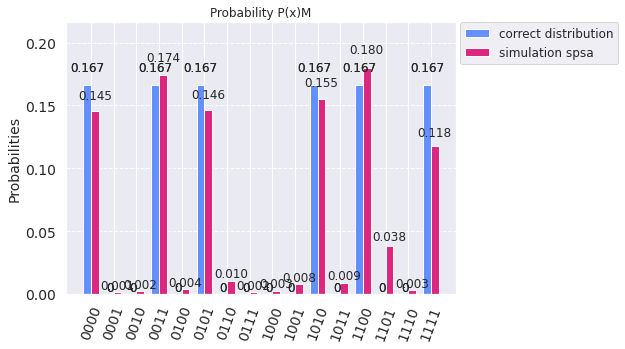

In [ ]:
psi_dict_spsa = psi_vqc_spsa.get_counts()
plot_histogram([dict_px_output,psi_dict_spsa], title='Probability P(x)M',
               legend=['correct distribution', 'simulation spsa'])

The above comparison was run between distribution of the data from this toy dataset and SPSA. The comparison was close but raised the qustion of using and trying other optimization methods such as COBYLA, Swarm etc.

**Applying the QCBM**

Finally, the parameters were used to derive output images as a verification of the performance of the QCBM

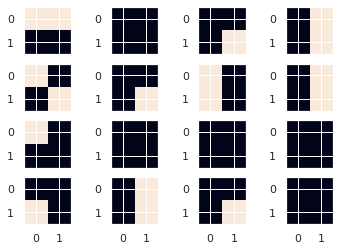

In [ ]:
def born_machine_valid_random(params):
    n=4
    list_n = range(n)
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    
    qc.measure(list_n,list_n)
    shots= 1 #Number of shots
    job = execute( qc, Aer.get_backend('qasm_simulator'),shots=shots )
    counts = job.result().get_counts() #Count the results of the execution
    return counts.keys()


matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(born_machine_valid_random(params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    

    
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.show()